In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2022-10-25 17:42 (eradiate v0.22.5.post10+g9337c14b.d20221025)*

## Geometry control interface

We start by activating the IPython extension and importing and aliasing a few useful components. We also select the monochromatic mode.

In [2]:
%load_ext eradiate

import attr
import numpy as np
import xarray as xr

import eradiate
from eradiate import unit_registry as ureg
eradiate.set_mode("mono")

In [3]:
exp_ppa = eradiate.experiments.AtmosphereExperiment(
    geometry="plane_parallel",
    atmosphere={
        "type": "molecular",
        "construct": "ussa_1976",
    },
    measures={
        "type": "perspective",
        "origin": [-1000, 0, 110] * ureg.km,
        "target": [0, 0, 110] * ureg.km,
        "up": [0, 0, 1],
        "film_resolution": (320, 160),
        "spp": 128
    }
)

Now, we run the simulation and plot the resulting image.

Mitsuba:   0%|          | 00:00, ETA=?

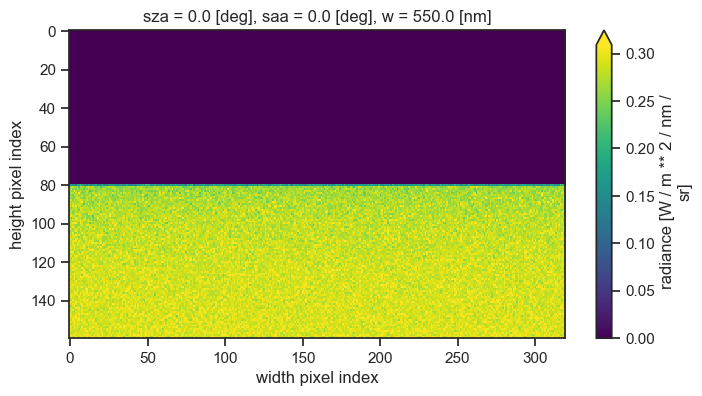

In [4]:
result = eradiate.run(exp_ppa)
result.radiance.squeeze().plot.imshow(
    yincrease=False, robust=True, aspect=2, size=4
)

Our surface is a horizontal line, just as we expected. Now, we can define a second experiment, which will be indentical, except for the problem geometry. To achieve this, all we have to do is set the `geometry` parameter to `"spherical_shell"`:

In [5]:
exp_ssa = eradiate.experiments.AtmosphereExperiment(
    geometry="spherical_shell",
    atmosphere=exp_ppa.atmosphere,
)

We can visualise the settings which were automatically selected. The planet radius is that of Earth, but it can be set to any value by passing directly a `SphericalShellGeometry` instance as the `geometry` parameter.

In [6]:
exp_ssa.geometry

SphericalShellGeometry(planet_radius=6378.1 km)

We also have to update our perspective camera setup because the scene is now based on a sphere centred at (0, 0, 0), and not a rectangular surface. Consequently, we must change where our camera is located and where it is looking.

In [7]:
camera_ppa = exp_ppa.measures[0]
offset = [0, 0, exp_ssa.geometry.planet_radius.m_as(ureg.km)] * ureg.km

exp_ssa = eradiate.experiments.AtmosphereExperiment(
    geometry="spherical_shell",
    atmosphere=exp_ppa.atmosphere,
    measures={
        "type": "perspective",
        "origin": camera_ppa.origin + offset,
        "target": camera_ppa.target + offset,
        "up": camera_ppa.up,
        "film_resolution": camera_ppa.film_resolution,
        "spp": camera_ppa.spp
    }
)

We run the simulation and display the resulting image, on which the curvature of the surface is clearly visible.

Mitsuba:   0%|          | 00:00, ETA=?

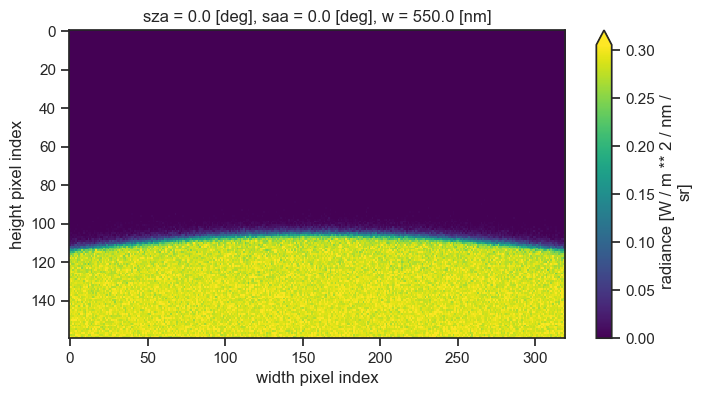

In [8]:
result = eradiate.run(exp_ssa)
result.radiance.squeeze().plot.imshow(
    yincrease=False, robust=True, aspect=2, size=4
)

## BRF simulation

Now that we know how to set the surface geometry, let us run a few top-of-atmosphere BRF simulations. We define two also identical experiments, one with a plane-parallel geometry, and the other with a spherical-shell geometry. A good setup to observe the effect of how switching to a spherical-shell geometry is decreases the optical path is to use an abstract example with a non-absorbing atmosphere model and a black surface.

In [9]:
experiments = {}

for geometry in ["plane_parallel", "spherical_shell"]:
    experiments[geometry] = eradiate.experiments.AtmosphereExperiment(
        geometry=geometry,
        atmosphere={
            "type": "molecular",
            "construct": "ussa_1976",
            "has_scattering": True,
            "has_absorption": False,
        },
        surface={"type": "black"},
        illumination={
            "type": "directional",
            "zenith": 0 * ureg.deg,
        },
        measures={
            "type": "mdistant",
            "construct": "hplane",
            "zeniths": (
                [-88, -87, -86] + 
                list(np.arange(-85, 86, 5)) + 
                [86, 87, 88]
            ) * ureg.deg,
            "azimuth": 0.0,
            "spp": 100000,
        }
    )

We can now run the simulation.

In [10]:
results = {}
for geometry, experiment in experiments.items():
    results[geometry] = eradiate.run(experiment)

Mitsuba:   0%|          | 00:00, ETA=?

Mitsuba:   0%|          | 00:00, ETA=?

The xarray library makes it very simple to assemble our results into a single dataset. We can then visualise it very conveniently.

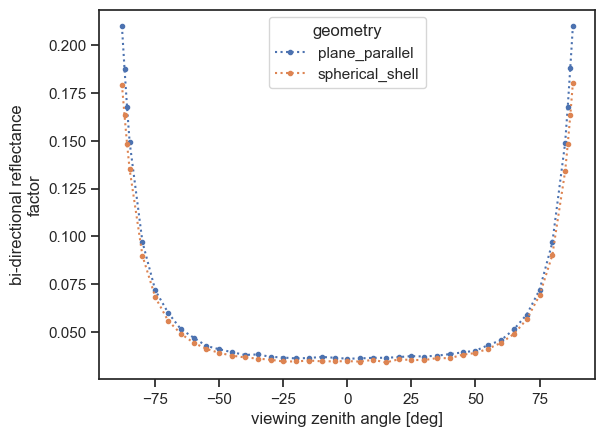

In [11]:
ds = xr.concat(list(results.values()), dim="geometry")
ds = ds.assign_coords(geometry=list(results.keys()))
ds.brf.squeeze(drop=True).plot(
    hue="geometry", x="vza", linestyle=":", marker="."
);

Note how the reduced optical path in the spherical-shell configuration also reduces the amount of light scattered to the sensor, and therefore decreases the recorded radiance.